# 7 Visualise activity in a video.

We have extracted all the features we plan to use. Overlaying these on the video was useful.
But watching annotated videos is inefficient and not always informative.. 

To help with understanding we build a few tools that let's see at a glance what happens over time.

In [1]:
import os
import utils
import calcs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ultralytics

In [2]:
videos_in = os.path.join("..","LookitLaughter.test")
demo_data = os.path.join("..","data", "demo")
temp_out = os.path.join("..","data","0_temp")
data_out = os.path.join("..","data","1_interim")
videos_out = os.path.join("..","data","2_final")

metadata_file = "_LookitLaughter.xlsx"

#a couple of files for testing
VIDEO_FILE  = os.path.join(videos_in, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(videos_in, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")
AUDIO_FILE = os.path.join(data_out, "2UWdXP.joke1.rep2.take1.Peekaboo.wav")
SPEECH_FILE = os.path.join(data_out, "2UWdXP.joke1.rep2.take1.Peekaboo.json")

testset = [VIDEO_FILE, VIDEO_FILE2] 

processedvideos = utils.getprocessedvideos(data_out)
processedvideos.head()

Found existing processedvideos.xlsx


,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Speech.file,Speech.when,Objects.file,Objects.when,Understand.file,Understand.when,Faces.normed,Keypoints.normed,annotatedVideo,annotated.when
0,2UWdXP.joke1.rep2.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,217,14.298910,...,../data/1_interim/2UWdXP.joke1.rep2.take1.Peek...,2023-09-20 16:58:38,NaN,NaN,NaN,NaN,../data/1_interim/2UWdXP.joke1.rep2.take1.Peek...,../data/1_interim/2UWdXP.joke1.rep2.take1.Peek...,../data/2_final/2UWdXP.joke1.rep2.take1.Peekab...,2024-02-16 11:03:50
1,2UWdXP.joke1.rep3.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,152,14.359089,...,../data/1_interim/2UWdXP.joke1.rep3.take1.Peek...,2023-09-20 16:58:39,NaN,NaN,NaN,NaN,../data/1_interim/2UWdXP.joke1.rep3.take1.Peek...,../data/1_interim/2UWdXP.joke1.rep3.take1.Peek...,../data/2_final/2UWdXP.joke1.rep3.take1.Peekab...,2024-02-16 11:03:51
2,2UWdXP.joke2.rep1.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,95,13.241315,...,../data/1_interim/2UWdXP.joke2.rep1.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN,../data/1_interim/2UWdXP.joke2.rep1.take1.NomN...,../data/1_interim/2UWdXP.joke2.rep1.take1.NomN...,../data/2_final/2UWdXP.joke2.rep1.take1.NomNom...,2024-02-16 11:03:52
3,2UWdXP.joke2.rep2.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,97,14.213813,...,../data/1_interim/2UWdXP.joke2.rep2.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN,../data/1_interim/2UWdXP.joke2.rep2.take1.NomN...,../data/1_interim/2UWdXP.joke2.rep2.take1.NomN...,../data/2_final/2UWdXP.joke2.rep2.take1.NomNom...,2024-02-16 11:03:53
4,2UWdXP.joke2.rep3.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,133,14.223092,...,../data/1_interim/2UWdXP.joke2.rep3.take1.NomN...,2023-09-20 16:58:48,NaN,NaN,NaN,NaN,../data/1_interim/2UWdXP.joke2.rep3.take1.NomN...,../data/1_interim/2UWdXP.joke2.rep3.take1.NomN...,../data/2_final/2UWdXP.joke2.rep3.take1.NomNom...,2024-02-16 11:03:54


# 7.1 Use Voxel51 and PytorchVideo for examining videos

Voxel51 seems to be a useful tool for looking at training data (and trained predictions).

Let's start with the minimal implementation. Just viewing videos.

https://docs.voxel51.com/user_guide/dataset_creation/index.html



In [3]:
import fiftyone as fo

### 7.1.1 Is dataset already created?

FiftyOne may aleady have a dataset created. Let's check. And reload it. 

In [4]:
datasets = fo.list_datasets()
if len(datasets) == 0:
    print("No datasets found. Load in step 7.1.2")
else:
    print("Loading saved datasets: ", datasets[0])
    dataset = fo.load_dataset(datasets[0])

No datasets found. Load in step 7.1.2


### 7.1.2 Populate a FiftyOne dataset with our videos and labels.

Either there is no existing dataset or we want to rebuild it.

In [5]:
fo.delete_datasets("*")

In [6]:
# Create a dataset from a directory of videos
dataset = fo.Dataset.from_videos_dir("../LookitLaughter.test")
dataset.ensure_frames()

dataset.name = 'LookitLaughter.test'


dataset.add_sample_field("JokeType", fo.StringField, description="What joke is being told?")
dataset.add_sample_field("HowFunny", fo.StringField, description="How funny is the joke?")
dataset.add_sample_field("LaughYesNo",  fo.BooleanField, description="Did the child laugh?")

 100% |███████████████████| 54/54 [48.8ms elapsed, 0s remaining, 1.1K samples/s]   
Computing metadata...
 100% |███████████████████| 54/54 [1.2s elapsed, 0s remaining, 45.5 samples/s]         


Now let's see if we can add our metadata classifications. Recalling that each video demos one joke type `[Peekaboo,TearingPaper,NomNomNom,ThatsNotAHat,ThatsNotACat]` and has rating of how funny the baby found it `[Not Funny, Slightly Funny, Funny, Extremely Funny]` and whether they laughed `[Yes, No]`.


In [7]:
# add the joke type, how funny and laugh yes/no for each sample in the dataset
for sample in dataset:
    #split the filepath to get the video name, system independent
    videoname = os.path.basename(sample.filepath)
    row = processedvideos[processedvideos["VideoID"]==videoname]
    sample["VideoID"]  = row["VideoID"].values[0]
    sample["JokeType"]  = row["JokeType"].values[0]
    sample["HowFunny"]  = row["HowFunny"].values[0]
    sample["LaughYesNo"]  = (row["LaughYesNo"].values[0] == "Yes")
    sample.save()

Let's add the frame by frame annotations directly onto the videos inside fiftyone

In [8]:
#Let's start with people bounding boxes

for sample in dataset:
    #retrieve people bounding boxes from the keypoints file
    keypoints = utils.readKeyPointsFromCSV(processedvideos,sample.filepath,normed= True)    

    for index, row in keypoints.iterrows():
        framenumber = row["frame"] + 1
        person = row["person"]
        bbox = [row["bbox.x1"], row["bbox.y1"], row["bbox.x2"], row["bbox.y2"]]
        bbox51 = calcs.xyxy2ltwh(bbox)
        if sample.frames[framenumber]:
            frame = sample.frames[framenumber]
        else:
            frame = fo.Frame()
        frame[person] = fo.Detection(label=person, bounding_box=bbox51)
        sample.frames[framenumber] = frame
        #TODO fiftyone add keypoints not well documented and i can't get it to work. 
        #frame[person + "KeyPoints"] =  
        #fo.KeypointSkeleton()
        #TODO can't see how to add timesynced captions either!

        sample.save()
        
dataset.save()

## 7.2 View dataset in Voxel51 GUI

In [9]:
# session = fo.launch_app(dataset)
# docker 
session = fo.launch_app(dataset) #, address="0.0.0.0", port=5151)

In [10]:
print(session.selected)

['663259e9fe74747f1a8bcee7']


In [11]:
#session.selected contains the indices of the dataset samples clicked on in the UI.
if len(session.selected) == 0:
    print("No samples selected. Click the checkbox in the top left of each video to select it.")
else:
    print(dataset[session.selected[0]])

<Sample: {
    'id': '663259e9fe74747f1a8bcee7',
    'media_type': 'video',
    'filepath': '/usr/src/babyjoke/LookitLaughter.test/3dC3SQ.joke1.rep3.take1.TearingPaper.mp4',
    'tags': [],
    'metadata': <VideoMetadata: {
        'size_bytes': 1450846,
        'mime_type': 'video/mp4',
        'frame_width': 640,
        'frame_height': 480,
        'frame_rate': 7.467478846504445,
        'total_frame_count': 136,
        'duration': 18.212305,
        'encoding_str': 'avc1',
    }>,
    'JokeType': 'TearingPaper',
    'HowFunny': 'Funny',
    'LaughYesNo': True,
    'VideoID': '3dC3SQ.joke1.rep3.take1.TearingPaper.mp4',
    'frames': <Frames: 136>,
}>


# 7.2 Draw annotated timeline for a select video 

A group of visualisations to see what happens in a video. 

In each frame let's find the `centre of gravity` for each person (the average of all the high-confidence marker points). This is handy for time series visualisation. For example plotting the cog.x for each person over time shows how they move closer and further from each other. 

Let's get the keypoint data and calculate

In [20]:


emotionColors = {"angry":{"color":"red","arousal":0.9,"valence":-0.2},
                 "fear":{"color":"orange","arousal":0.2,"valence":-0.9},
                 "happy":{"color":"yellow","arousal":0.2,"valence":0.9},
                 "neutral":{"color":"grey","arousal":0,"valence":0},
                 "sad":{"color":"blue","arousal":-0.2,"valence":-0.9},
                 "surprise":{"color":"green","arousal":0.9,"valence":0.2},
                 "disgust":{"color":"purple","arousal":-0.7,"valence":-0.7}}
who = ["child", "adult"]

We have a speech data file for 4JDccE.joke2.rep3.take1.ThatsNotAHat.mp4
We have a face data file for 4JDccE.joke2.rep3.take1.ThatsNotAHat.mp4


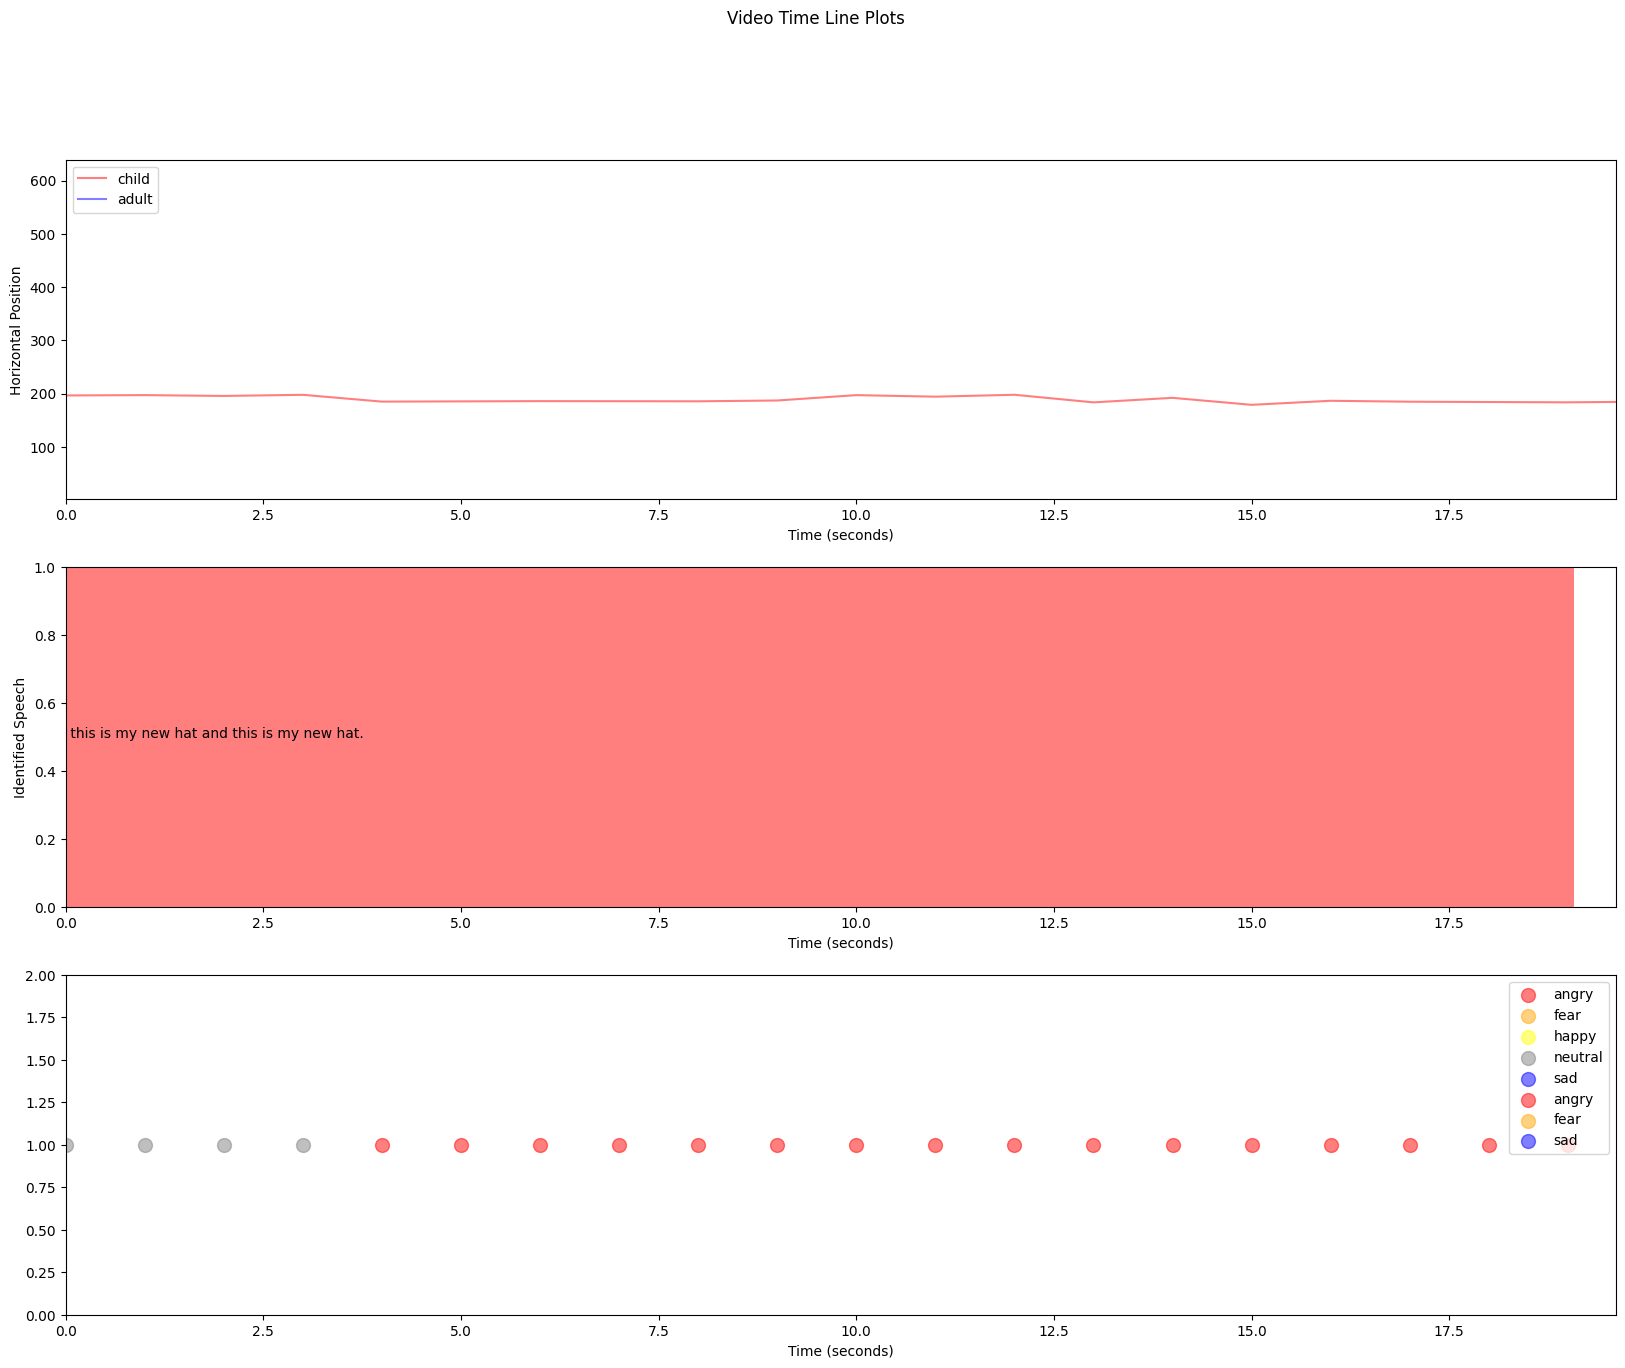

In [26]:
plotCoGrav = True
plotSpeech = True
plotEmotions = True

#numerical sum of boolean flags
subplots = sum([plotCoGrav, plotSpeech, plotEmotions])

if len(session.selected) == 0:
    print("No video selected")
    exit()

VideoID = dataset[session.selected[0]]["VideoID"]
keypoints = utils.readKeyPointsFromCSV(processedvideos,VideoID)
FPS = utils.getVideoProperty(processedvideos, VideoID, "FPS")
xmax = keypoints["frame"].max()
#this bit of pandas magic calculates average x and y for all the rows.
keypoints[["cogx","cogy"]] = keypoints.apply(lambda row: calcs.rowcogs(row.iloc[8:59]), axis=1, result_type='expand')

#going to add a subplot foe each of the above flags
plt.figure(figsize=(20, 5*subplots))
plt.suptitle("Video Time Line Plots")
pltidx = 0
if plotCoGrav:
    ax = plt.subplot(subplots, 1, pltidx + 1)
    pltidx += 1
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Horizontal Position")
    ax.set_xlim(0, xmax/FPS)
    child = keypoints[keypoints["person"]=="child"]
    adult = keypoints[keypoints["person"]=="adult"]
    #a plot of child's centre of gravity frame by frame
    childplot = ax.plot(child["frame"], child["cogx"], c="red", alpha=0.5)
    ## add line of adult's centre of gravity
    adultplot = ax.plot(adult["frame"], adult["cogx"], c="blue", alpha=0.5)
    #add legend
    ax.legend(['child', 'adult'], loc='upper left')

if plotSpeech:
    ax2 = plt.subplot(subplots, 1, pltidx + 1)
    pltidx += 1
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Identified Speech")
    speechjson = utils.getSpeechData(processedvideos,VideoID)
    if speechjson is not None:
        nsegs = len(speechjson["segments"])
        ax2.set_xlim(0, xmax/FPS)
        ax2.set_ylim(0, nsegs)
        #let's plot the speech segments as boxes
        #label each one with the text
        for idx, seg in enumerate(speechjson["segments"]):
            # #rectangle with the start and end times as x coordinates and nsegs - idx as y coordinates
            #fill the rectangle
            ax2.fill([seg["start"], seg["end"], seg["end"], seg["start"]], [nsegs - idx - 1, nsegs - idx - 1, nsegs - idx, nsegs - idx], 'r', alpha=0.5)
            ax2.text(seg["start"], nsegs- idx -.5 , seg["text"])

if plotEmotions:
    ax3 = plt.subplot(subplots, 1, pltidx + 1)
    pltidx += 1
    ax3.set_xlabel("Time (seconds)")
    ax3.set_ylim(0, 2)
    ax3.set_xlim(0, xmax/FPS)  
    emotions = utils.getFaceData(processedvideos,VideoID)
    emotions["ticker"] = 1
    for index in range(2):
        ems = emotions[emotions["index"]==index]
        #who is the person we are plotting
        # key gives the emotion name, data gives the actual values (also labels)
        for key, data in ems.groupby('emotion'):
            #plot scatter plot of emotion occurances
            ax3.scatter(data["frame"], data["ticker"] + index, label=key, c=emotionColors[key]["color"], alpha=0.5, s=100)

        
    #show legend with emotion colours
    plt.legend(loc='best')





plt.show()




Let's plot the captions.
Go through the speechjson. For each speech segment add a horizotal line with the text. Start and End times from the speechjson.

Now let's do a timeline for the emotions of the participants.
We'll experiment to find best visualisation. 
Note this assumes that faces are correctly assigned to correct indviduals. 
TODO - Code that uses bounding boxes to assign faces to individuals.

First we will try a 'scatter' graph. Color coded for each emotion. 